In [1]:
%matplotlib qt4
%matplotlib inline


# Spectral Unmixing


S. Somnath\ :sup:`1,2`,  R. K. Vasudevan\ :sup:`1,3`
* :sup:`1` Institute for Functional Imaging of Materials
* :sup:`2` Advanced Data and Workflows Group
* :sup:`3` Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

In this notebook we load some spectral data, and perform basic data analysis, including:
========================================================================================
* KMeans Clustering
* Non-negative Matrix Factorization
* Principal Component Analysis

Software Prerequisites:
=======================
* Standard distribution of **Anaconda** (includes numpy, scipy, matplotlib and sci-kit learn)
* **pycroscopy** : Though pycroscopy is mainly used here for plotting purposes only, it's true capabilities
  are realized through the ability to seamlessly perform these analyses on any imaging dataset (regardless
  of origin, size, complexity) and storing the results back into the same dataset among other things




In [2]:
#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py
import hyperspy.api as hs

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for downloading files:
import wget
import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

# finally import pycroscopy:
import pycroscopy as px

"""
  
"""

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'\n  \n'

The Data
========

In this example, we will work on a **Band Excitation Piezoresponse Force Microscopy (BE-PFM)** imaging dataset
acquired from advanced atomic force microscopes. In this dataset, a spectra was colllected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with the pycroscopy data format.

Fortunately, all statistical analysis, machine learning, spectral unmixing algorithms, etc. only accept data that is
formatted in the same manner of [position x spectra] in a two dimensional matrix.

We will begin by downloading the BE-PFM dataset from Github




In [3]:
data_file_path = 'EELS spectrum image.h5'
#folder_path = 'D:/Books/research/IMAGE/20180110_TMD/'
#folder_name = '150_3'
#file_name = folder_path + folder_name + '/EELS Spectrum Image.h5'
#raw = hs.load(file_name,signal_type='EELS')
# :
hdf = px.ioHDF5(data_file_path)
h5_file = hdf.file

print('Contents of data file:')
print('----------------------')
px.hdf_utils.print_tree(h5_file)
print('----------------------')

h5_meas_grp = h5_file['Measurement_000']
parm_dict=px.hdf_utils.get_attributes(h5_meas_grp)

print('The attibutes include:')
for key in parm_dict:
    print(key,':',parm_dict[key])


# Getting a reference to the main dataset:
h5_main = h5_meas_grp['Channel_000/Raw_Data']
h5_proc = h5_meas_grp['Channel_000/Processed/Processed_Data']
h5_proc[np.isnan(h5_proc[()])]=0

h5_thick = h5_meas_grp['Channel_000/Processed/Thickness']
# Extracting some basic parameters:
num_rows = px.hdf_utils.get_attr(h5_meas_grp,'num_rows')
num_cols = px.hdf_utils.get_attr(h5_meas_grp,'num_cols')
#spec_vals = px.hdf_utils.get_attr(h5_meas_grp,'spec_axis')
new_spec_vals = px.hdf_utils.getAuxData(h5_proc,'Spectroscopic_Values')[0][0]

print('Data currently of shape:', h5_main.shape)

print(np.shape(new_spec_vals))
x_label = 'Energy Loss (eV)'
y_label = 'Counts'


Contents of data file:
----------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Processed
Measurement_000/Channel_000/Processed/Position_Indices
Measurement_000/Channel_000/Processed/Position_Values
Measurement_000/Channel_000/Processed/Processed_Data
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/Component_Indices
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/S
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/U
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/V
Measurement_000/Channel_000/Processed/Spectroscopic_Indices
Measurement_000/Channel_000/Processed/Spectroscopic_Values
Measurement_000/Channel_000/Processed/Thickness
Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spect

In [7]:
h5_proc[np.isnan(h5_proc[()])]=0

In [4]:
data_file_path = 'EELS spectrum image.h5'
# :
hdf = px.ioHDF5(data_file_path)
h5_file = hdf.file

print('Contents of data file:')
print('----------------------')
px.hdf_utils.print_tree(h5_file)
print('----------------------')

h5_meas_grp = h5_file['Measurement_000']
h5_try = h5_meas_grp['Channel_000/Position_Indices']
print(h5_try)
#print(spec_vals)

Contents of data file:
----------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Processed
Measurement_000/Channel_000/Processed/Position_Indices
Measurement_000/Channel_000/Processed/Position_Values
Measurement_000/Channel_000/Processed/Processed_Data
Measurement_000/Channel_000/Processed/Spectroscopic_Indices
Measurement_000/Channel_000/Processed/Spectroscopic_Values
Measurement_000/Channel_000/Processed/Thickness
Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values
----------------------
<HDF5 dataset "Position_Indices": shape (342, 2), type "<u4">


Visualize the Amplitude Data
============================
Note that we are not hard-coding / writing any tick labels / axis labels by hand.
All the necessary information was present in the H5 file



In [5]:
px.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_proc)

KeyError: "'labels' is not an attribute in '/Measurement_000/Channel_000/Processed/Position_Indices'"

1. Singular Value Decomposition (SVD)
=====================================

SVD is an eigenvector decomposition that is defined statistically, and therefore typically produces
non-physical eigenvectors. Consequently, the interpretation of eigenvectors and abundance maps from
SVD requires care and caution in interpretation. Nontheless, it is a good method for quickly
visualizing the major trends in the dataset since the resultant eigenvectors are sorted in descending
order of variance or importance. Furthermore, SVD is also very well suited for data cleaning through
the reconstruction of the dataset using only the first N (most significant) components.

SVD results in three matrices:
* V - Eigenvectors sorted by variance in descending order
* U - corresponding bundance maps
* S - Variance or importance of each of these components

Advantage of pycroscopy:
------------------------
Notice that we are working with a complex valued dataset. Passing the complex values as is to SVD would result in
complex valued eigenvectors / endmembers as well as abundance maps. Complex valued abundance maps are not physical.
Thus, one would need to restructure the data such that it is real-valued only.

One solution is to stack the real value followed by the magnitude of the imaginary component before passing to SVD.
After SVD, the real-valued eigenvectors would need to be treated as the concatenation of the real and imaginary
components. So, the eigenvectors would need to be restructured to get back the complex valued eigenvectors.

**Pycroscopy handles all these data transformations (both for the source dataset and the eigenvectors)
automatically.**  In general, pycroscopy handles compund / complex valued datasets everywhere possible

Furthermore, while it is not discussed in this example, pycroscopy also writes back the results from SVD back to
the same source h5 file including all relevant links to the source dataset and other ancillary datasets



Performing SVD
SVD took 0.31 seconds.  Writing results to file.


(<matplotlib.figure.Figure at 0x199cf240>,
 <matplotlib.axes._axes.Axes at 0x199cfa58>)

(<matplotlib.figure.Figure at 0x199cf198>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019A27F60>,
       dtype=object))

(<matplotlib.figure.Figure at 0x199cf208>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AA46748>,
       dtype=object))

(<matplotlib.figure.Figure at 0x1a99a8d0>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x1adeb9b0>)

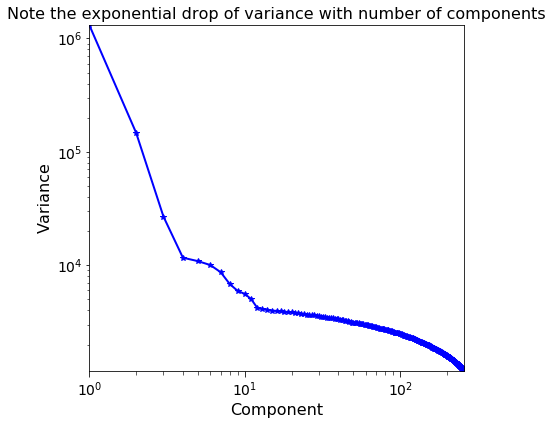

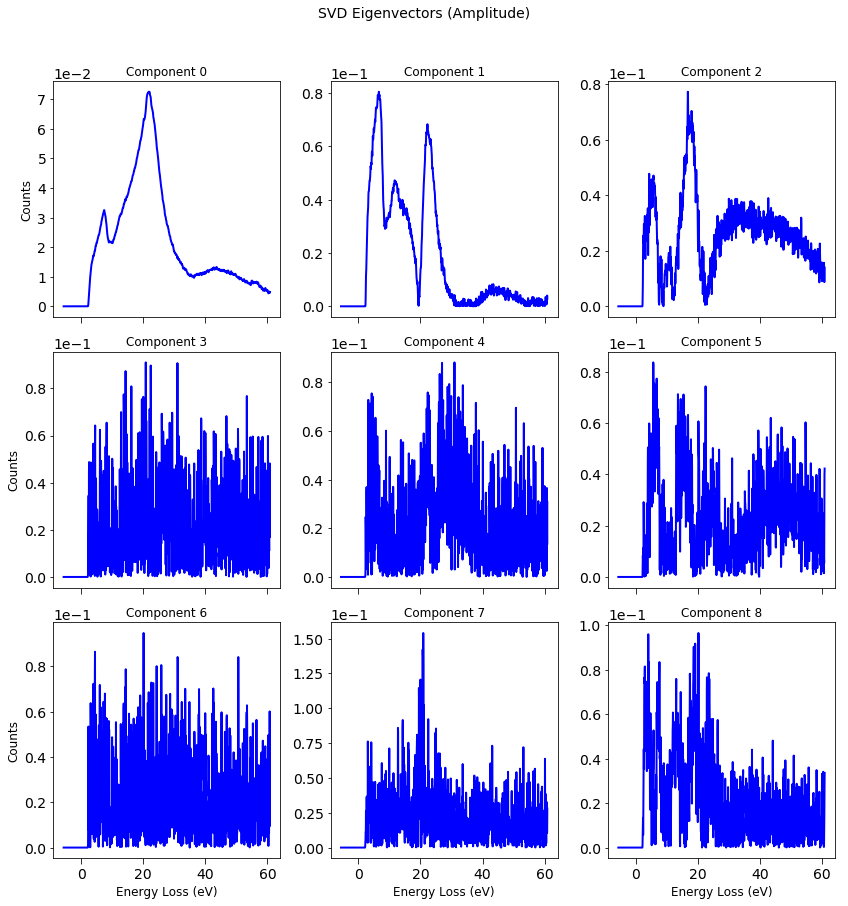

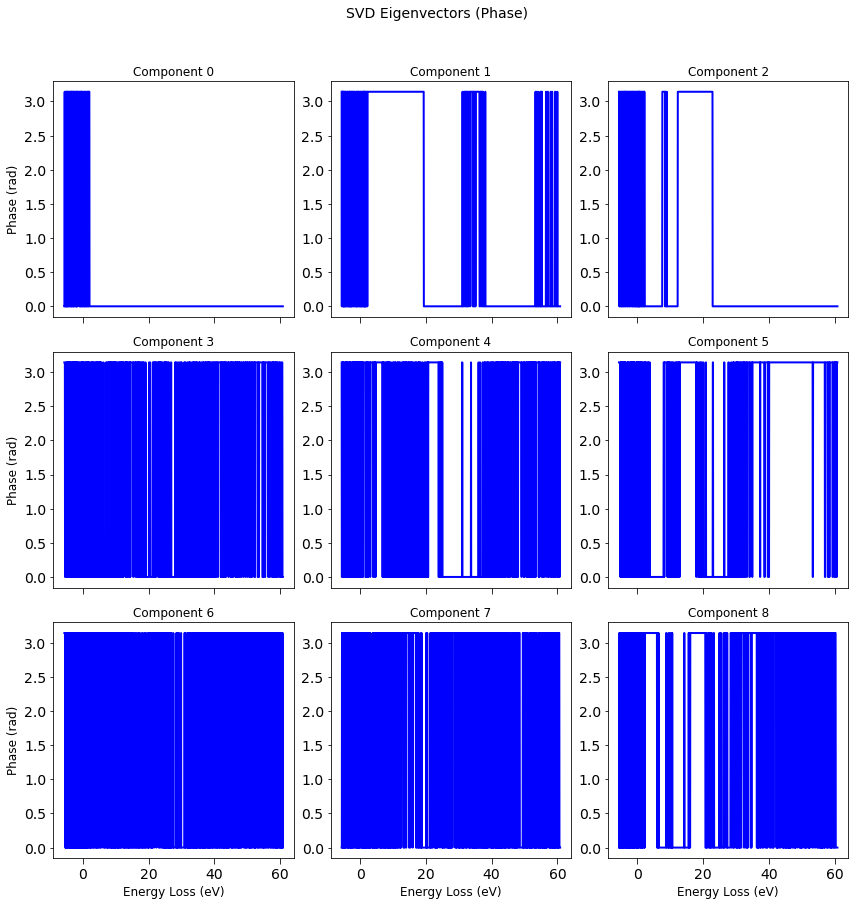

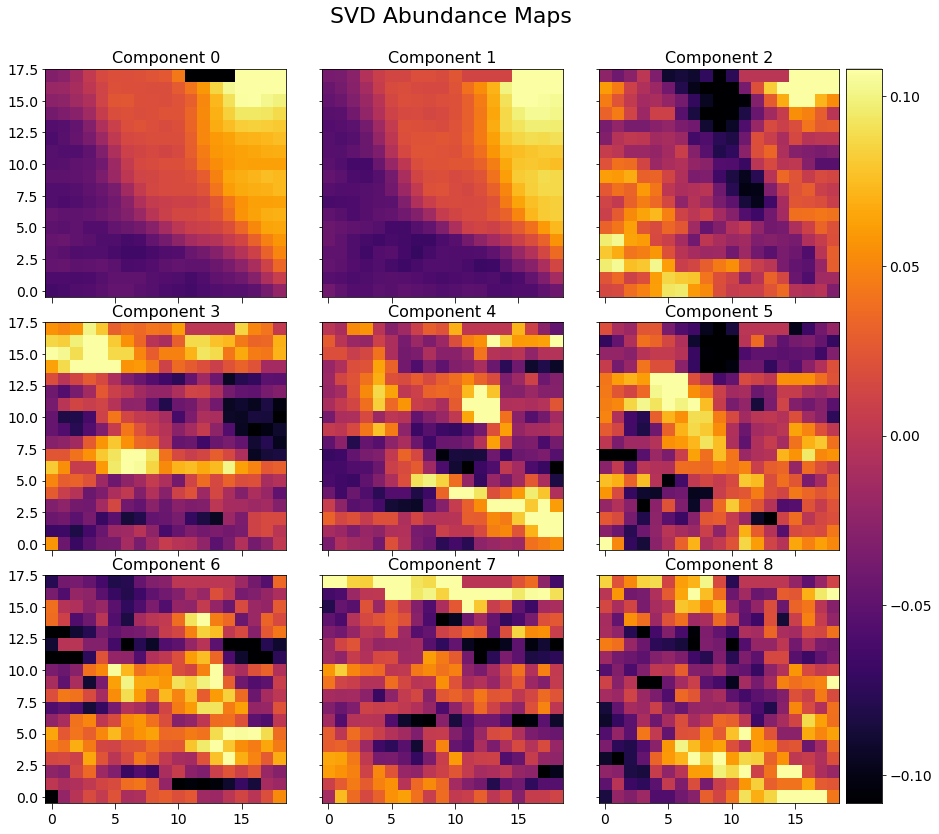

In [9]:
#h5_svd_group = px.doSVD(h5_main, num_comps=256)
do_svd = px.processing.svd_utils.SVD(h5_proc, num_components=256)
h5_svd_group = do_svd.compute()

h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols, -1))

# Visualize the variance / statistical importance of each component:
px.plot_utils.plot_scree(h5_s, title='Note the exponential drop of variance with number of components')

# Visualize the eigenvectors:
first_evecs = h5_v[:9, :]

px.plot_utils.plot_loops(new_spec_vals, np.abs(first_evecs), x_label=x_label, y_label=y_label, plots_on_side=3,
                         subtitle_prefix='Component', title='SVD Eigenvectors (Amplitude)', evenly_spaced=False)
px.plot_utils.plot_loops(new_spec_vals, np.angle(first_evecs), x_label=x_label, y_label='Phase (rad)', plots_on_side=3,
                         subtitle_prefix='Component', title='SVD Eigenvectors (Phase)', evenly_spaced=False)

# Visualize the abundance maps:
px.plot_utils.plot_map_stack(abun_maps, num_comps=9, heading='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno')

In [ ]:
%store -d sig

2. KMeans Clustering
====================

KMeans clustering is a quick and easy method to determine the types of spectral responses present in the
data. It is not a decomposition method, but a basic clustering method. The user inputs the number of
clusters (sets) to partition the data into. The algorithm proceeds to find the optimal labeling
(ie., assignment of each spectra as belonging to the k<sup>th</sup> set) such that the within-cluster
sum of squares is minimized.

Set the number of clusters below

We can use this method to cluster the thickness and disinguish different layers or interfaces.



In [6]:
import numpy as np
from sklearn.cluster import KMeans

In [7]:
num_clusters = 3
thickmat = np.array(h5_thick[()])
stdmat = np.zeros((num_rows-2,num_cols-2))
for i in range(1,num_rows-1):
    for j in range(1,num_cols-1):
        row = np.array([[i-1,i,i+1]]).astype(int)
        col = np.array([[j-1,j,j+1]]).astype(int)
        rowmat = np.transpose(np.dot(np.ones((3,1)).astype(int),row))
        colmat = np.dot(np.ones((3,1)).astype(int),col)
        test = np.reshape(thickmat[rowmat,colmat],(-1))
        stdmat[i-1,j-1] = np.std(test)
    

feature1 = np.reshape(h5_thick[1:num_rows-1,1:num_cols-1],(-1))
feature2 = np.reshape(stdmat,(-1))
task = np.transpose(np.array([feature1,feature2]))

estimator = KMeans(n_clusters=num_clusters)
estimator.fit(task)
label_pred = estimator.labels_ 
centroids = estimator.cluster_centers_ 
inertia = estimator.inertia_ 


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
import pandas as pd
frame = pd.DataFrame(task,columns=['Thickness','Variance'])
frame['Label']=label_pred
frame.shape

(272, 3)

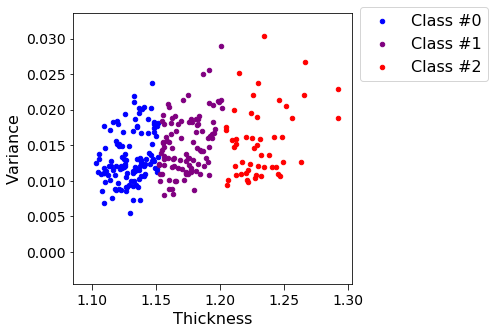

In [9]:
ax = frame[frame['Label']==0].plot.scatter(x='Thickness',y='Variance',label='Class #{}'.format(0),color=[0,0,1])

for i in range(1,num_clusters):
    frame[frame['Label']==i].plot.scatter(x='Thickness',y='Variance',label='Class #{}'.format(i),ax=ax,color=[i/(num_clusters-1),0,1-i/(num_clusters-1)])
    
ax.legend(bbox_to_anchor=(1, 1.05))

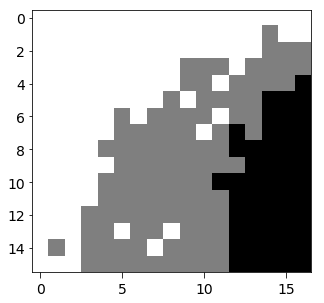

In [10]:
pos = np.reshape(range(frame.shape[0]),(num_rows-2,num_cols-2))
pos_label = np.reshape(label_pred,(num_rows-2,num_cols-2))
plt.imshow(pos_label,cmap='binary')

In [ ]:
err = []
for i in range(1,10):
    estimator = KMeans(n_clusters=i);#构造聚类器
    %time estimator.fit(task)#聚类
    err.append(estimator.inertia_) # 获取聚类准则的总和
    
plt.plot(range(1,10),err,'o')

3. Non-negative Matrix Factorization (NMF)
===========================================

NMF, or non-negative matrix factorization, is a method that is useful towards unmixing of spectral
data. It only works on data with positive real values. It operates by approximate determination of
factors (matrices) W and H, given a matrix V, as shown below

![](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)


Unlike SVD and k-Means that can be applied to complex-valued datasets, NMF only works on non-negative datasets.
For illustrative purposes, we will only take the amplitude component of the spectral data



Text(0.5,0,'Energy Loss (eV)')

Text(0,0.5,'Counts')

Text(0.5,1,'NMF Components')

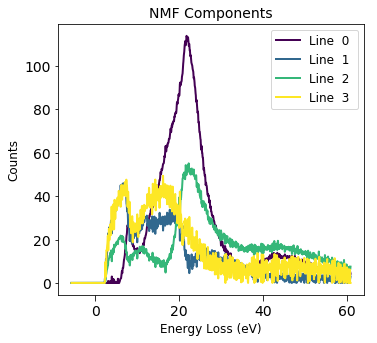

In [10]:
num_comps = 4

# get the non-negative portion of the dataset
data_mat = np.abs(h5_proc)
#data_mat[np.isnan(stdmat)] = 0
model = NMF(n_components=num_comps, init='random', random_state=0)
W = model.fit_transform(data_mat)
H = model.components_

fig, axis = plt.subplots(figsize=(5.5, 5))
px.plot_utils.plot_line_family(axis, new_spec_vals, model.components_, label_prefix='NMF Component #')
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0, 1.0], fontsize=12)

In [ ]:
fig1, axes1 = plt.subplots(2,3,figsize=(13,10),sharex=True,sharey=True)
for i in range(np.shape(H)[0]):
    ind1 = i//3
    ind2 = i%3
    axes1[ind1,ind2].plot(new_spec_vals,H[i,:])
    axes1[ind1,ind2].set_title('Component #{}'.format(i),fontsize=14)

(22, 22, 4)

Text(0.5,1,'Component #0')

Text(0.5,1,'Component #1')

Text(0.5,1,'Component #2')

Text(0.5,1,'Component #3')

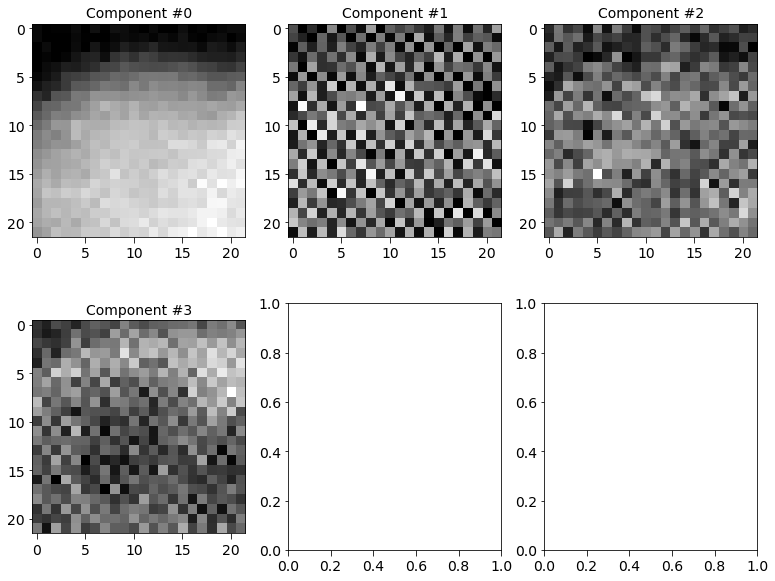

In [12]:
ext_W  = np.reshape(W,(num_rows,num_cols,-1))
np.shape(ext_W)
fig, axes = plt.subplots(2,3,figsize=(13,10))
for i in range(np.shape(ext_W)[2]):
    ind1 = i//3
    ind2 = i%3
    axes[ind1,ind2].imshow(ext_W[:,:,i])
    axes[ind1,ind2].set_title('Component #{}'.format(i),fontsize=14)    